<a href="https://colab.research.google.com/github/rahulrajpr/milestone_projects/blob/main/food_vision101/DeepLearning_FoodVision101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# version control on tensorflow
from IPython.display import clear_output
!pip install tensorflow==2.9.0
clear_output()
import tensorflow as tf
tf.__version__

'2.9.0'

> Import usual libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')

> Bench Mark Paper

https://arxiv.org/pdf/1606.05675.pdf

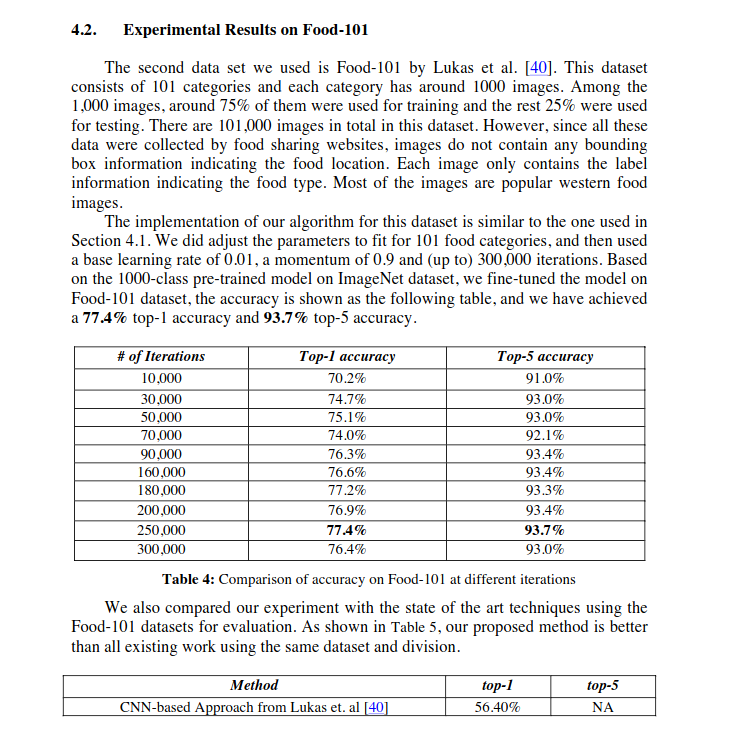

> Check the GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-866905e1-0508-d17f-104e-0f08701b23a5)


In this project, we use mixprecision to accelarate the model training, which works to its benifit in GPU with computation power > 7.0

> Get the helper functions.py

In [ ]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py

--2023-02-24 03:13:39--  https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12000 (12K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.72K  --.-KB/s    in 0s      

2023-02-24 03:13:39 (89.5 MB/s) - ‘helper_functions.py’ saved [12000/12000]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

> Lets Define the Global variables

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

> Get the DataSet from TensorFlow DataSet

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
dataset_list = tfds.list_builders()
dataset_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

In [ ]:
'food101' in dataset_list

True

`food101` data set is in the dataset_list of tensorflow dataset

> Download the dataset

In [ ]:
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised= True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteU1994Q/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteU1994Q/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


> Exploring the Dataset

- Classes
- Shape
- Data Type
- One Sample

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path=PosixGPath('/tmp/tmp0wnp33vftfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_exam

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

Things to note that:
- the tensors datatype is uint8 in tha dataset
- The class is not one-hot encoded, but lable encoded

Lets get the classes of the dataset

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

> Examine one Sample

In [ ]:
one_sample = train_data.take(1)
one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in one_sample:

  print(
      f"""
      image : {image[:2]}
      image_shape : {image.shape}
      inage_dtype : {image.dtype}
      label : {label}
      lable_shape : {label.shape}
      class_name : {class_names[label]}
      """
  )


      image : [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]
      image_shape : (512, 512, 3)
      inage_dtype : <dtype: 'uint8'>
      label : 56
      lable_shape : ()
      class_name : huevos_rancheros
      


Inference : 

- The images are of diffrent shapes(image sizes)
- The images are not not normalized
- The datatypes are of uint8 type

lets plot one of the image

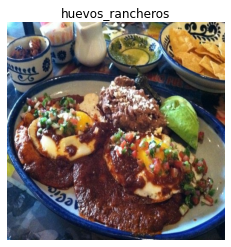

In [ ]:
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

> Create a preprocessing function so that it can be put into a function

In [ ]:
def image_preprocess(image, label, image_size = (224,224)):
  
  # resize the image
  image = tf.image.resize(image, size = image_size)
  # convert into float32
  image = tf.cast(image, dtype = tf.float32)
  # rescale
  #image = image/255.0 # this is not required when we use the efficientnet framework

  return image, label

Lets apply the preprocessing function in one of the sample image

In [ ]:
image_preprocessed = image_preprocess(image, label)
image_preprocessed

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[230.65816  , 253.64285  , 251.       ],
         [222.99998  , 254.97449  , 252.19388  ],
         [207.06633  , 255.       , 250.36734  ],
         ...,
         [140.66287  , 129.52519  , 121.22428  ],
         [121.14268  , 115.26515  , 116.95397  ],
         [ 83.95363  ,  83.08119  ,  89.63737  ]],
 
        [[221.47449  , 254.37755  , 253.33163  ],
         [214.5102   , 255.       , 253.92348  ],
         [198.41327  , 254.58673  , 251.96939  ],
         ...,
         [208.66318  , 195.82143  , 173.40823  ],
         [197.03056  , 190.1071   , 174.83162  ],
         [175.54036  , 171.6169   , 161.21384  ]],
 
        [[204.21428  , 253.42857  , 249.57143  ],
         [198.71428  , 254.64287  , 251.2449   ],
         [185.04591  , 251.73979  , 252.21428  ],
         ...,
         [222.45403  , 207.47444  , 169.35715  ],
         [216.52551  , 205.01024  , 172.02556  ],
         [215.51529  , 207.87244  , 177.58672 

Lets plot the preprocessed image

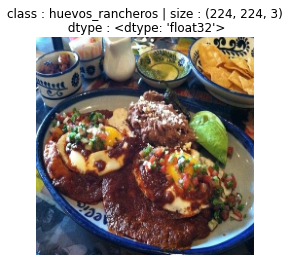

In [ ]:
plt.imshow(image_preprocessed[0]/255.0)
plt.title(f"class : {class_names[image_preprocessed[1]]} | size : {image_preprocessed[0].shape}\n dtype : {image_preprocessed[0].dtype}")
plt.axis(False);

> Preprocess the dataset

- Preprocess the dataset by mapping the above function using the `dataset.map function`
- Batch the dataset for the faster training using the `dataset.batch` function

Note the usage of `num_paralell_calls : tf.data.AUTOTUNE` and `.prefetch(tf.data.AUTOTUNE)`

tf.data.AUTOTUNE ask the kernal to use the all the available CPU's to do parellel processing of the given task

In [ ]:
# mapping the preprocessing function to the train data

train_data = train_data.map(map_func = image_preprocess, num_parallel_calls = tf.data.AUTOTUNE)

# batching the train data after shuffling

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [ ]:
# Applyin the same thing on the test_data but not to do shuffling

test_data = test_data.map(map_func = image_preprocess, num_parallel_calls = tf.data.AUTOTUNE)

test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

Lets look at the shape of the train and the test datasets

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
len(train_data), len(test_data)

(2368, 790)

> Create Modeling callbacks 

In [ ]:
from helper_functions import create_tensorboard_callback

In [ ]:
checkpoint_path = 'checkpoints/cp.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, 
                                                monitor= 'val_accuracy', 
                                                save_weights_only = True,
                                                save_best_only = True,
                                                verbose = 0)

> Set up the Mixed Precsion training

In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16') # This enable the model to compute in float 16 whereever possible 

In [ ]:
# mixed_precision.global_policy()

> Building the efficentnet model with mixed precision ( For Feature Extraction - with Backbone model is not trainable)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [ ]:
tf.random.set_seed(42)

# define the backbone model

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)

base_model.trainable = False

# create model using the application API

inputs = layers.Input(shape = IMG_SIZE+(3,), name = 'input_layer')

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(units = len(class_names))(x)

# this step necessiry as we use the mixed precision and the data type needs to converted to float32 as they are only stable in terms varibles
outputs = layers.Activation(activation = 'softmax', dtype = tf.float32, name = 'output_layer')(x)

model = tf.keras.Model(inputs,outputs)

# compile model

model.compile(loss = 'sparse_categorical_crossentropy', # since the lables are in integer form, not in one-hot encoded form
              optimizer = Adam(),
              metrics = ['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


> Lets check the model parameters

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
output_layer True float32 <Policy "float32">


lets check the sam for the backbone model

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation Fal

> Lets train the first model

In [ ]:
!nvidia-smi

Fri Feb 24 03:24:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |    340MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history_0 = model.fit(train_data,
                      epochs = 5,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [create_tensorboard_callback(dir_name = 'tensorboard_callbacks',
                                                               experiment_name = 'food101_efficientnetB0_feature_extraction'),
                                   checkpoint])

Saving TensorBoard log files to: tensorboard_callbacks/food101_efficientnetB0_feature_extraction/20230224-032433
Epoch 1/5
2368/2368 [==============================] - 231s 91ms/step - loss: 1.7787 - accuracy: 0.5674 - val_loss: 1.1224 - val_accuracy: 0.6947
Epoch 2/5
2368/2368 [==============================] - 205s 86ms/step - loss: 1.2662 - accuracy: 0.6710 - val_loss: 1.0306 - val_accuracy: 0.7132
Epoch 3/5
2368/2368 [==============================] - 213s 88ms/step - loss: 1.1312 - accuracy: 0.7032 - val_loss: 0.9888 - val_accuracy: 0.7267
Epoch 4/5
2368/2368 [==============================] - 203s 85ms/step - loss: 1.0432 - accuracy: 0.7240 - val_loss: 0.9676 - val_accuracy: 0.7315
Epoch 5/5
2368/2368 [==============================] - 202s 84ms/step - loss: 0.9812 - accuracy: 0.7396 - val_loss: 0.9670 - val_accuracy: 0.7309


Lets evaluate the model

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 0.9675 - accuracy: 0.7366


[0.9675086736679077, 0.7366336584091187]

> Lets Save the model

In [ ]:
model.save('/content/saved_models/feature_extraction')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/saved_models/feature_extraction')
loaded_model

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 80ms/step - loss: 0.9675 - accuracy: 0.7366


[0.9675092101097107, 0.7366336584091187]

Lets examine the model visually

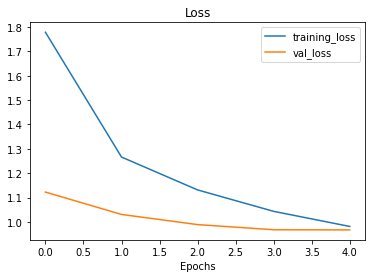

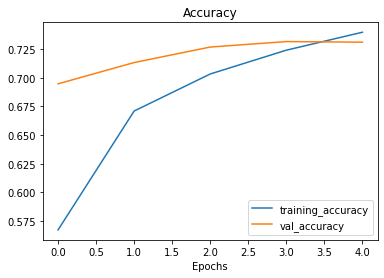

In [ ]:
plot_loss_curves(history_0)

Lets do some fine tuning for the model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

Fine tuning the Feature extraction Model

In [ ]:
# modify the backbone model
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# recompile the model

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(lr = 0.0001), 
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_____________________________________________

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
output_layer True


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
# lets fit the fine tune model

fine_tune_epochs = 10

history_1 = model.fit(train_data,
                      epochs = fine_tune_epochs,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history_0.epoch[-1],
                      callbacks = [create_tensorboard_callback(dir_name = 'tensorborad_callbacks',
                                                               experiment_name = 'food101_efficientnet_fine_tuning1')])

Saving TensorBoard log files to: tensorborad_callbacks/food101_efficientnet_fine_tuning1/20230224-035806
Epoch 5/10
2368/2368 [==============================] - 216s 87ms/step - loss: 0.9426 - accuracy: 0.7487 - val_loss: 0.8972 - val_accuracy: 0.7511
Epoch 6/10
2368/2368 [==============================] - 208s 87ms/step - loss: 0.8097 - accuracy: 0.7833 - val_loss: 0.8704 - val_accuracy: 0.7582
Epoch 7/10
2368/2368 [==============================] - 207s 86ms/step - loss: 0.7344 - accuracy: 0.8033 - val_loss: 0.8670 - val_accuracy: 0.7585
Epoch 8/10
2368/2368 [==============================] - 206s 85ms/step - loss: 0.6729 - accuracy: 0.8226 - val_loss: 0.8414 - val_accuracy: 0.7696
Epoch 9/10
2368/2368 [==============================] - 208s 87ms/step - loss: 0.6213 - accuracy: 0.8349 - val_loss: 0.8470 - val_accuracy: 0.7683
Epoch 10/10
2368/2368 [==============================] - 206s 86ms/step - loss: 0.5763 - accuracy: 0.8472 - val_loss: 0.8361 - val_accuracy: 0.7738


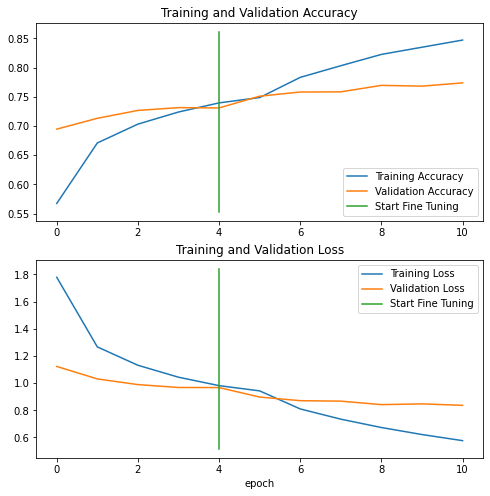

In [ ]:
compare_historys(history_0,history_1, initial_epochs = 5)

In [ ]:
# lets save the model

model.save('/content/saved_models/feature_extraction_fine_tune1')

In [ ]:
loaded_model_fine_tune1 = tf.keras.models.load_model('/content/saved_models/feature_extraction_fine_tune1')

In [ ]:
loaded_model_fine_tune1.evaluate(test_data)

790/790 [==============================] - 73s 90ms/step - loss: 0.8438 - accuracy: 0.7670


[0.8437617421150208, 0.7670099139213562]

Seems like our model is improving the their performance in as we train for more epochs

- how will you decide how much epochs required - we can use early stopping callback with 100 epochs

In [ ]:
# lets create a early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

# lets create a checkpoint instace 

checkpoint_100_epoch = tf.keras.callbacks.ModelCheckpoint(filepath = 'check_point_100_epoch',
                                                          monitor = 'val_accuray',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          save_weights_only = True)

# reduce learning rate based on performance on validation accuracy                                                          

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                            factor = 0.2,
                                                            patience = 2, 
                                                            verbose = 1,
                                                            min_lr = 1e-7)

Get the model back to the feature extraction state

In [ ]:
model.load_weights(filepath = 'checkpoints/cp.ckpt')

In [ ]:
# lets check the model is loaded with the correct checkpointed weights

model.evaluate(test_data)

790/790 [==============================] - 73s 92ms/step - loss: 0.9754 - accuracy: 0.7339


[0.9754393696784973, 0.7339009642601013]

 Lets create the trainable base model, and recompile the model

In [ ]:
# modifying the base model

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

# recompiling the model

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(0.0001),
              metrics = ['accuracy'])

lets fit the model for 100 epochs with early stopping callbacks

In [ ]:
history_3 = model.fit(train_data,
                      epochs = 100,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history_0.epoch[-1],
                      callbacks = [create_tensorboard_callback(dir_name = 'tensorboard_callbacks',
                                                               experiment_name = 'food101_efficientnet_fine_tuning2'),
                                   early_stopping,
                                   checkpoint_100_epoch,
                                   reduce_learning_rate])

Saving TensorBoard log files to: tensorboard_callbacks/food101_efficientnet_fine_tuning2/20230224-053827
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9763 - accuracy: 0.7425

2368/2368 [==============================] - 217s 87ms/step - loss: 0.9764 - accuracy: 0.7424 - val_loss: 0.9035 - val_accuracy: 0.7492 - lr: 1.0000e-04
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8504 - accuracy: 0.7742

2368/2368 [==============================] - 209s 87ms/step - loss: 0.8504 - accuracy: 0.7742 - val_loss: 0.8688 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.7957

2368/2368 [==============================] - 208s 87ms/step - loss: 0.7694 - accuracy: 0.7957 - val_loss: 0.8574 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.8119

2368/2368 [==============================] - 209s 87ms/step - loss: 0.7079 - accuracy: 0.8119 - val_loss: 0.8502 - val_accuracy: 0.7643 - lr: 1.0000e-04
Epoch 9/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.8262

2368/2368 [==============================] - 208s 87ms/step - loss: 0.6565 - accuracy: 0.8262 - val_loss: 0.8241 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.8396

2368/2368 [==============================] - 219s 91ms/step - loss: 0.6108 - accuracy: 0.8396 - val_loss: 0.8277 - val_accuracy: 0.7715 - lr: 1.0000e-04
Epoch 11/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5679 - accuracy: 0.8508

2368/2368 [==============================] - 261s 109ms/step - loss: 0.5679 - accuracy: 0.8508 - val_loss: 0.8339 - val_accuracy: 0.7699 - lr: 1.0000e-04
Epoch 12/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5310 - accuracy: 0.8621

2368/2368 [==============================] - 208s 87ms/step - loss: 0.5310 - accuracy: 0.8621 - val_loss: 0.8204 - val_accuracy: 0.7749 - lr: 1.0000e-04
Epoch 13/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4973 - accuracy: 0.8727

2368/2368 [==============================] - 205s 85ms/step - loss: 0.4973 - accuracy: 0.8727 - val_loss: 0.8230 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 14/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8818


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 205s 85ms/step - loss: 0.4657 - accuracy: 0.8818 - val_loss: 0.8160 - val_accuracy: 0.7728 - lr: 1.0000e-04
Epoch 15/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.9035

2368/2368 [==============================] - 204s 85ms/step - loss: 0.4030 - accuracy: 0.9035 - val_loss: 0.8067 - val_accuracy: 0.7773 - lr: 2.0000e-05
Epoch 16/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.9070

2368/2368 [==============================] - 205s 86ms/step - loss: 0.3924 - accuracy: 0.9070 - val_loss: 0.8120 - val_accuracy: 0.7778 - lr: 2.0000e-05
Epoch 17/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3866 - accuracy: 0.9096

2368/2368 [==============================] - 212s 89ms/step - loss: 0.3867 - accuracy: 0.9095 - val_loss: 0.8077 - val_accuracy: 0.7781 - lr: 2.0000e-05
Epoch 18/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.9116

2368/2368 [==============================] - 206s 86ms/step - loss: 0.3777 - accuracy: 0.9115 - val_loss: 0.8210 - val_accuracy: 0.7762 - lr: 2.0000e-05
Epoch 19/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.9129


Epoch 19: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 206s 86ms/step - loss: 0.3708 - accuracy: 0.9129 - val_loss: 0.8162 - val_accuracy: 0.7760 - lr: 2.0000e-05
Epoch 20/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9176

2368/2368 [==============================] - 204s 85ms/step - loss: 0.3591 - accuracy: 0.9176 - val_loss: 0.8168 - val_accuracy: 0.7744 - lr: 4.0000e-06


In [ ]:
model.save('/content/saved_models/feature_extraction_fine_tune2')

In [ ]:
loaded_model_fine_tune2 = tf.keras.models.load_model('/content/saved_models/feature_extraction_fine_tune2')

In [ ]:
loaded_model_fine_tune2.evaluate(test_data)

790/790 [==============================] - 63s 77ms/step - loss: 0.8145 - accuracy: 0.7781


[0.814463198184967, 0.7781386375427246]

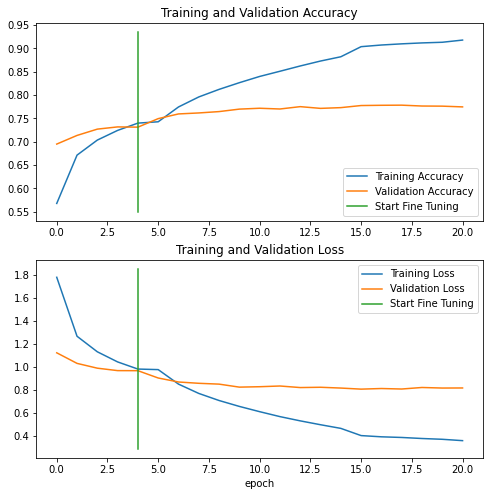

In [ ]:
compare_historys(history_0,history_3,5)

Lets get the best epoch from the checkpoints

In [ ]:
model.load_weights('check_point_100_epoch')

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 0.8265 - accuracy: 0.7740


[0.8265040516853333, 0.7739802002906799]